# XAI CODE DEMO

## Explainable AI Specialization on Coursera

If you experience high latency while running this notebook, you can open it in Google Colab:

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/explainable-machine-learning/interpretable-ml/blob/main/generalized_models_interpretability.ipynb)

# Generalized Models

* Generalized Linear Models (GLMs)
* Generalized Additive Models (GAMs)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import Log
from statsmodels.tools import add_constant
from pygam import LinearGAM, GammaGAM, s
import seaborn as sns

#### Dataset

We will be using the Diabetes datastet for this demonstration: [LINK](https://www.geeksforgeeks.org/sklearn-diabetes-dataset/)

This dataset is from [Efron, et.al.](https://hastie.su.domains/Papers/LARS/LeastAngle_2002.pdf)

The features in this dataset are age, sex, bmi, blood pressure (bp), and six serum measurements (s1-s6).

In [2]:
# Load the Diabetes dataset
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

# The target variable needs to be positive for Gamma GLM
y = y - y.min() + 1  # Shift and scale to ensure all values are positive

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Generalized Linear Model (GLM)

* Keep the weighted sum of the features, but allow non-Gaussian outcome distributions and connect the expected mean of this distribution and the weighted sum through a possibly nonlinear function.

#### Gamma GLM with log link

* Gamma Distribution: The response variable Y is assumed to follow a Gamma distribution. The Gamma distribution is often used for modeling continuous, positive-valued data that are skewed.

* Log Link Function: The log link function is used to connect the linear predictor 𝜂 to the mean 𝜇 of the Gamma-distributed response variable

In [3]:
# Fit a Gamma GLM with log link
X_train_const = add_constant(X_train_scaled)
X_test_const = add_constant(X_test_scaled)
glm = GLM(y_train, X_train_const, family=Gamma(link=Log()))
glm_results = glm.fit()

# Make predictions
y_pred_glm = glm_results.predict(X_test_const)

# Calculate MSE and R^2
mse_glm = mean_squared_error(y_test, y_pred_glm)
r2_glm = r2_score(y_test, y_pred_glm)

print(f"GLM MSE: {mse_glm:.4f}, R^2: {r2_glm:.4f}")

# Interpret GLM
print("\nGLM Coefficients:")
for feature, coef in zip(['Intercept'] + list(diabetes.feature_names), glm_results.params):
    print(f"{feature}: {coef:.4f}")

GLM MSE: 2961.5598, R^2: 0.4410

GLM Coefficients:
Intercept: 4.7627
age: 0.0239
sex: -0.1286
bmi: 0.1623
bp: 0.1449
s1: -0.4973
s2: 0.3876
s3: 0.0230
s4: 0.0141
s5: 0.3837
s6: 0.0006


### Coefficient Plot

Plot the coefficients in a visual way to see relative importance of features.

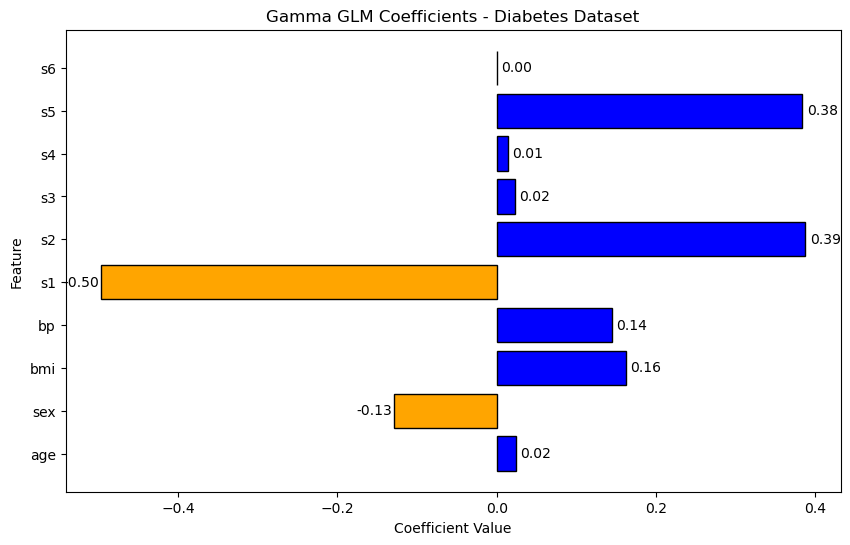

In [4]:
# Extract the coefficients and feature names
feature_names = list(diabetes.feature_names)
coefficients = glm_results.params[1:]

# Map the sign of coefficients to colors
colors = ['blue' if coef > 0 else 'orange' for coef in coefficients]

# Plot the coefficients
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_names, coefficients, color=colors, edgecolor='black')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Gamma GLM Coefficients - Diabetes Dataset')

for bar, coef in zip(bars, coefficients):
    plt.text(bar.get_width() + np.sign(bar.get_width()) * 0.025, bar.get_y() + bar.get_height() / 2, f'{coef:.2f}',
             va='center', ha='center')

plt.show()

## Generalized Additive Model (GAM)

* GAMs assume that the outcome can be modeled by a sum of arbitrary functions of each feature
* GAMs use B splines, which allow us to automatically model non-linear relationships
* GAM is still a sum of feature effects, but it gives the option to allow nonlinear relationships between some features and the output

#### Terminology
* LinearGAM: uses a Normal (Gaussian) error distribution
* s(*i*): Represents a spline term for the *i*th feature, allowing for flexible, non-linear relationships between the feature and the response variable

We are using the pygam library. Documentation [here](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html).

* The gridsearch method performs a grid search over a pre-defined range of hyperparameters to find the best set of hyperparameters (smoothing parameters for each spline term). The method evaluates different combinations of hyperparameters using cross-validation on the training data and selects the combination that minimizes the cross-validation error.

In [5]:
# Initilize GAM
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9))

# Find best smoothing parameters for each spline term
gam.gridsearch(X_train_scaled, y_train)

# Fit the model
gam.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gam = gam.predict(X_test_scaled)

# Calculate MSE and R^2
mse_gam = mean_squared_error(y_test, y_pred_gam)
r2_gam = r2_score(y_test, y_pred_gam)

print(f"GAM MSE: {mse_gam:.4f}, R^2: {r2_gam:.4f}")

gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:01:13 Time:  0:01:130:05


GAM MSE: 2750.6111, R^2: 0.4808
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     17.7204
Link Function:                     IdentityLink Log Likelihood:                                 -3136.0639
Number of Samples:                          353 AIC:                                             6309.5686
                                                AICc:                                             6311.784
                                                GCV:                                             3162.6608
                                                Scale:                                           2878.2281
                                                Pseudo R-Squared:                                   0.5501
Featu

### GAM - Partial Dependence Plots
Plots the partial dependence of each feature, showing the effect of each feature on the predicted outcome while holding other features constant.

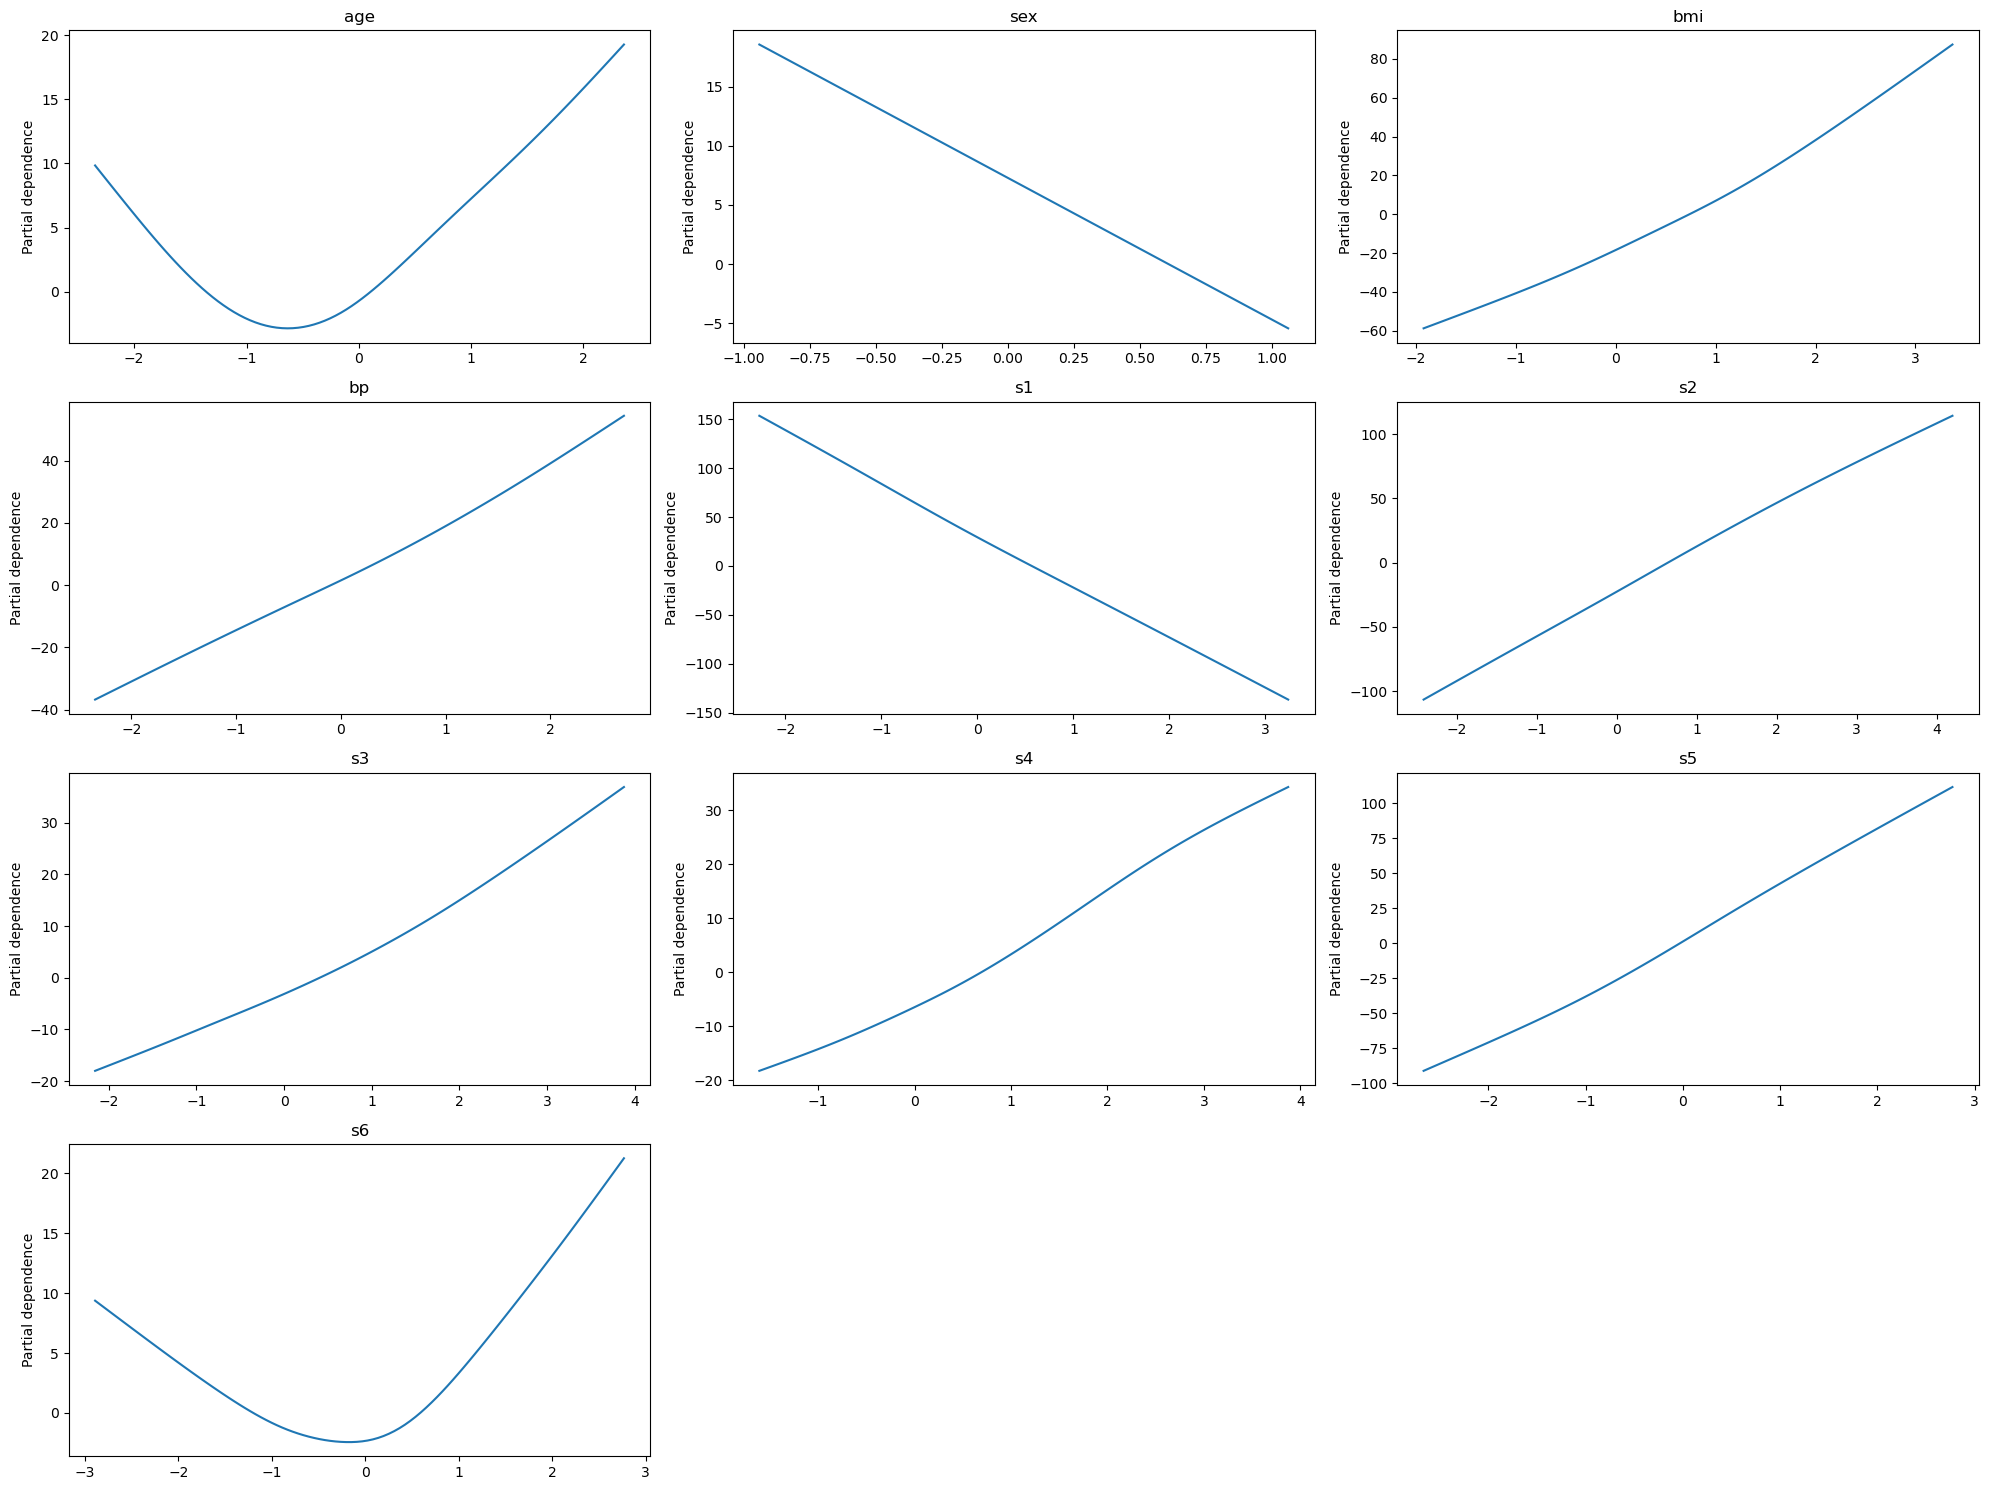

In [6]:
# Visualize GAM
plt.figure(figsize=(20, 15))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(4, 3, i+1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))
    plt.title(diabetes.feature_names[i])
    plt.ylabel('Partial dependence')
plt.tight_layout()
plt.show()